The purpose of this notebook is the respond to the "enova interview challenge." Namely, given the data, we are trying to determine whether or not a subject is alive 7 years after diagnosis. 

In [1]:
if 0:
    !jupyter nbconvert --to script prostate.ipynb

# Usual load ins

In [46]:
import sys
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from collections import OrderedDict
from sklearn import metrics
from ggplot import *


# special sauce

In [3]:
sys.path.append('/Users/jameshorine/repos/private_code/core')
import core_functions as core


# File Load in 

In [4]:
train_file_path = '/Users/jameshorine/repos/prostate_cancer/data/training_data.csv'
scoring_file_path = '/Users/jameshorine/repos/prostate_cancer/data/name_score.csv'

In [5]:
train_data = pd.read_csv(train_file_path)
scoring_data = pd.read_csv(scoring_file_path)

In [6]:
use_impute = True

In [7]:
if use_impute:
    
    #imputation script
    ! Rscript /Users/jameshorine/repos/private_code/enova_challenge/code/imputation_code.R
    #paths
    imputed_train_file_path = '/Users/jameshorine/repos/prostate_cancer/data/imputed_training.csv'
    imputed_scoring_file_path = '/Users/jameshorine/repos/prostate_cancer/data/imputed_testing.csv'
    #files
    imputed_train_data = pd.read_csv(imputed_train_file_path)
    imputed_scoring_data = pd.read_csv(imputed_scoring_file_path)
    
    train_data[imputed_train_data.columns] = imputed_train_data
    scoring_data[imputed_scoring_data.columns] = imputed_scoring_data

Loading required package: mice
Loading required package: methods
Loading required package: lattice

 iter imp variable
  1   1  gleason_score  age  race  height  weight  family_history  first_degree_history  previous_cancer  smoker  tumor_diagnosis  tumor_1_year  psa_diagnosis  psa_6_months  psa_1_year  tea
  1   2  gleason_score  age  race  height  weight  family_history  first_degree_history  previous_cancer  smoker  tumor_diagnosis  tumor_1_year  psa_diagnosis  psa_6_months  psa_1_year  tea
  1   3  gleason_score  age  race  height  weight  family_history  first_degree_history  previous_cancer  smoker  tumor_diagnosis  tumor_1_year  psa_diagnosis  psa_6_months  psa_1_year  tea
  1   4  gleason_score  age  race  height  weight  family_history  first_degree_history  previous_cancer  smoker  tumor_diagnosis  tumor_1_year  psa_diagnosis  psa_6_months  psa_1_year  tea
  1   5  gleason_score  age  race  height  weight  family_history  first_degree_history  previous_cancer  smoker  tumor_d

In [8]:
sanity_check = False

In [9]:
if sanity_check:
    print("___________________________")
    print("___________________________")
    print("scoring")
    print("___________________________")
    print("___________________________")
    print(scoring_data.isnull().sum(axis = 0)/scoring_data.shape[0])
    print("___________________________")
    print("___________________________")
    print("testing")
    print("___________________________")
    print("___________________________")
    print(train_data.isnull().sum(axis = 0)/train_data.shape[0] )

We have an 89% survival rate from diagnosis

In [10]:
sum(train_data.survival_1_year)/train_data.shape[0]

0.89691257718557038

We have an 43% survival rate from diagnosis

In [11]:
sum(train_data.survival_7_years)/train_data.shape[0]

0.43230419239519013

In [12]:
train_data[(train_data['survival_1_year'] == 1) & (train_data['survival_7_years'] == 1)].shape

(6651, 33)

Sanity Check: 

In [13]:
train_data[(train_data['survival_1_year'] == 0) & (train_data['survival_7_years'] == 1)].shape

(0, 33)

# Fill in empty symptoms variable

In [14]:
train_data['symptoms'].fillna(value = 'empty_symptom_code', inplace = True)
train_data['symptoms'] = train_data.apply(lambda x: tuple(x.symptoms.split(',')), axis = 1)

In [15]:
scoring_data['symptoms'].fillna(value = 'empty_symptom_code', inplace = True)
scoring_data['symptoms'] = scoring_data.apply(lambda x: tuple(x.symptoms.split(',')), axis = 1)

# Applying multilabel binarizer 


In [16]:
mlb_training = MultiLabelBinarizer()
mlb_testing = MultiLabelBinarizer()

In [17]:
mlb_training.fit_transform(train_data['symptoms']).shape

(15385, 17)

In [18]:
mlb_training_data = core.mlb_setup(data=train_data, item_var='symptoms', mlb=mlb_training)

In [19]:
mlb_scoring_data = core.mlb_setup(data=scoring_data, item_var='symptoms', mlb=mlb_testing)

# Correlation Heat Map 

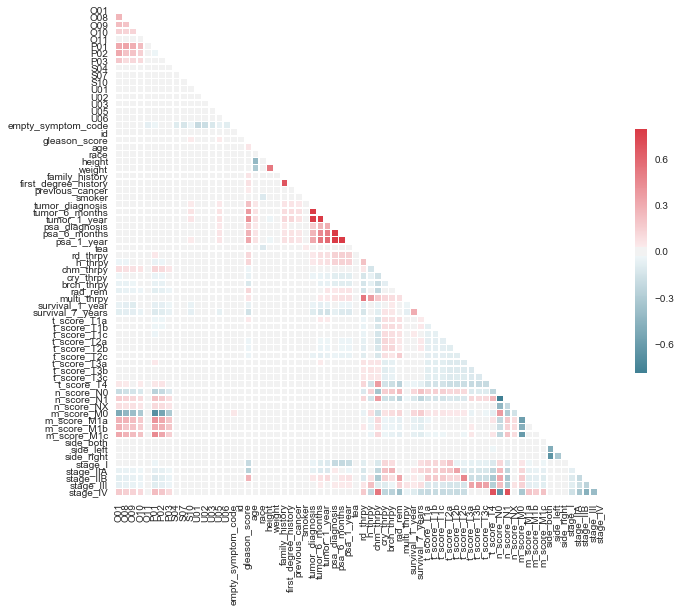

In [50]:
sns.set(style="white")
corr = clean_training.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

fig = corr_plot.get_figure()
fit.savefig("")

#swarm_plot = sns.swarmplot(...)
#fig = swarm_plot.get_figure()
#fig.savefig(...) 

# Defining Features and Targets 

In [20]:
target7 = 'survival_7_years'
target1 = 'survival_1_year' 


In [21]:
cat_cols = ['t_score', 'n_score', 'm_score', 'side', 'stage']


In [22]:
#one hot encoding

training_one_hot = pd.get_dummies(mlb_training_data[cat_cols])
clean_training = pd.concat([mlb_training_data, training_one_hot], axis = 1)  

scoring_one_hot = pd.get_dummies(mlb_scoring_data[cat_cols])
clean_scoring = pd.concat([mlb_scoring_data, scoring_one_hot], axis = 1)


In [23]:
features = [x for x in clean_training.isnull().sum(axis = 0).index[clean_training.isnull().sum(axis = 0) ==0] if x not in ['id', 'diagnosis_date', 'survival_7_years', 't_score', 'n_score', 'm_score', 'side', 'tumor_6_months','stage','symptoms']]           
imputer_features = [x for x in clean_training.isnull().sum(axis = 0).index[clean_training.isnull().sum(axis = 0) ==0] if x not in ['id', 'diagnosis_date', 'survival_1_year', 'survival_7_years', 't_score', 'n_score','tumor_6_months', 'm_score', 'side', 'stage','symptoms']]           
 

# Useful Code From SkLearn... Results check out with 10-fold CV 

In [24]:
RANDOM_STATE = 123

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True,
                               oob_score=True,
                               max_features="sqrt",
                               min_samples_leaf=5,
                               random_state=RANDOM_STATE)),
    
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True,
                               max_features='log2',
                               oob_score=True,
                               min_samples_leaf=5,
                               random_state=RANDOM_STATE)),
    
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True,
                               max_features=None,
                               oob_score=True,
                               min_samples_leaf=5,
                               random_state=RANDOM_STATE))
]

In [25]:
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X=clean_training[features], y=clean_training[target7])

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))



/Users/jameshorine/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jameshorine/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jameshorine/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jameshorine/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/jameshorine/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

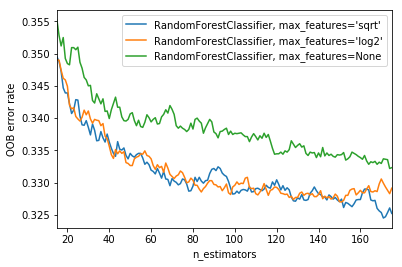

In [26]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.savefig('../plots/OOB_error_rate.pdf')
plt.show()


### Notes: square root hits a stable OOB error level faster than using $\text{log}_2$-many features OR all avaliable features.

# Random Forest and Imputer Random Forest fit

In [27]:
clf = RandomForestClassifier(max_features='sqrt')
clf_imputer = RandomForestClassifier(max_features='sqrt')


In [28]:
clf_imputer.fit(X=clean_training[imputer_features], y=clean_training[target1])
clf.fit(X=clean_training[features], y=clean_training[target7])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Importance

In [29]:
importance_imputed_1_year = clf_imputer.feature_importances_
importance_imputed_1_year = pd.DataFrame(importance_imputed_1_year, index=clean_training[imputer_features].columns, 
                          columns=["Importance"])


In [30]:
importance_7 = clf.feature_importances_
importance_7 = pd.DataFrame(importance_7, index=clean_training[features].columns, 
                          columns=["Importance"])


In [31]:
importance_7.sort_values(by = 'Importance', ascending = False).head(10)

,Importance
tumor_diagnosis,0.063712
weight,0.063512
tumor_1_year,0.063167
survival_1_year,0.062353
psa_6_months,0.061980
psa_diagnosis,0.061262
psa_1_year,0.061192
age,0.058949
gleason_score,0.041574
tea,0.036170


# Imputer 10-fold accuracy score

In [32]:
imputer_acc_score = (cross_val_score(cv=10, estimator=clf_imputer,X=clean_training[imputer_features], y=clean_training[target1], n_jobs=2)).mean()  
print(imputer_acc_score)

0.889827923385


# Random Forest 10-fold accuracy score

In [33]:
rf_acc_score = (cross_val_score(cv=10, estimator=clf,X=clean_training[features], y=clean_training[target7], n_jobs=2)).mean()  
print(rf_acc_score)

0.636851158383


# Imputing 1 year survival missing variable 

In [34]:
clean_scoring['survival_1_year'] = clf_imputer.predict(X=clean_scoring[imputer_features])

# Predicting 7 year survival

In [35]:
clean_scoring['survival_7_years'] = clf.predict(X=clean_scoring[features])

In [36]:
clean_scoring[['survival_7_years']].sum() / clean_scoring.shape[0]

survival_7_years    0.398491
dtype: float64

# ROC Curve 

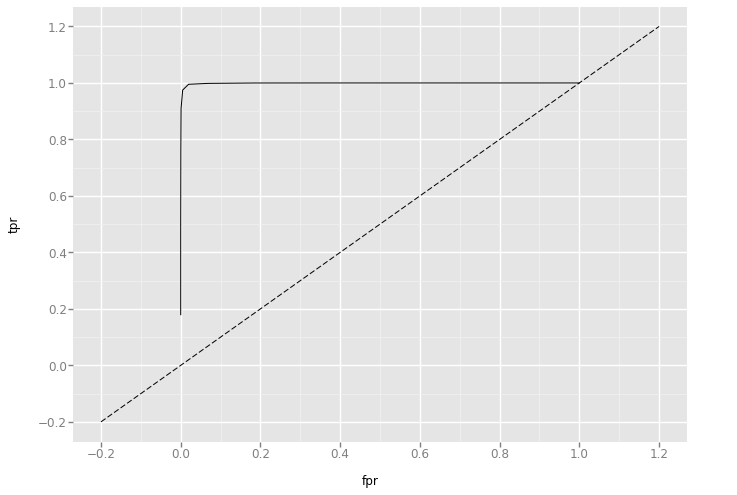

<ggplot: (-9223372036563088019)>

In [37]:
in_sample_preds = clf.predict_proba(clean_training[features])[:,1]
fpr, tpr, _ = metrics.roc_curve(clean_training['survival_7_years'], in_sample_preds)

df_in_sample = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df_in_sample, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')
 

In sample AUC

In [38]:
sk.metrics.roc_auc_score(y_true=clean_training[target7], y_score=in_sample_preds)


0.99906056712091817

# Data Write out 

In [39]:
save_file_path = '../data/james_score.csv'

In [40]:
clean_scoring.to_csv(path_or_buf=save_file_path ,index=False)